In [188]:
import numpy as np
import matplotlib as mp
import numpy.linalg as la
from decimal import Decimal
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import pylab
import math
import os

import networkx as nx
import plotly.graph_objs as go
import scipy
import scipy.linalg as spla
import scipy.sparse
import scipy.optimize
from scipy.interpolate import interp1d
#from scipy import interpolate

import meshio as meshio

In [11]:
path = 'data/'
err = 1e-04

#35.792 Nonzero
#7.043.716 Werte
#1327 Knoten
#2654 Freiheitsgrade

In [12]:
def getMatrix( pathMatrix ):
    matFile = open( pathMatrix, 'r')
    mat = np.zeros((2654,2654))
    next(matFile)

    #save values of the file in a matrix
    for line in matFile:
        if( line.strip() ):
            splitline = line.split(" ")
            mat[int(splitline[0])][int(splitline[1])] = float(splitline[2])
    matFile.close()
    return mat

def getVector( pathVector ):
    vecFile = open( pathVector, 'r')
    vec = np.zeros((2654))
    next(vecFile)

    #save values of the file in a matrix
    index = 0
    for line in vecFile:
        if( line.strip() ):
            vec[index] = line
            index += 1
    vecFile.close()
    return vec

In [13]:
def getBoundary( points ):
    min_x = 1e+10
    max_x = -1e+10
    min_y = 1e+10
    for i_points in points:
        if( i_points[0] < min_x ):
            min_x = i_points[0]
        elif( i_points[0] > min_x ):
            max_x = i_points[1]
        if( i_points[1] < min_y ):
            min_y = i_points[1]
    return min_x, max_x, min_y

In [453]:
def getEigenmode( mat, numEval ):
    w,v=spla.eig(mat)
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]

    return w[numEval], v.T[numEval]

def getSortedEigenvalues( mat ):
    w,v=spla.eig(mat)
    idx = w.argsort()[::1]   
    w = w[idx]
    v = v[:,idx]

    return w, v.T

def saveSmallestEigenvalues( path, file ):
    outFile = open( file, "a")
    list = os.listdir(path + 'Jac')
    list.sort()
    
    for i_path in list:
        print( i_path )
        mat = getMatrix( path + "Jac/" + i_path)
        mat = apply_Dirichlet_bc_boundary(mat, points, 0, leftX, rightX, bottomY)
        w,v = getEigenmode( mat, len(mat[0])-1 )
        outFile.write( str(w.real) + "\n")
        print(w)
    outFile.close()

saveSmallestEigenvalues( path, path + "eigenvalues/smallest.txt" )

stiffness_ogs_global_matrix_cnt_006_t_0.1_pcs_0_Jac.mat
(639.8956949092673+0j)
stiffness_ogs_global_matrix_cnt_011_t_0.2_pcs_0_Jac.mat
(639.8782516869338+0j)
stiffness_ogs_global_matrix_cnt_016_t_0.3_pcs_0_Jac.mat
(639.8730968358741+0j)
stiffness_ogs_global_matrix_cnt_021_t_0.4_pcs_0_Jac.mat
(639.8665298535732+0j)
stiffness_ogs_global_matrix_cnt_027_t_0.5_pcs_0_Jac.mat
(613.211020857535+0j)
stiffness_ogs_global_matrix_cnt_033_t_0.6_pcs_0_Jac.mat
(522.4632789136776+0j)
stiffness_ogs_global_matrix_cnt_040_t_0.7_pcs_0_Jac.mat
(280.81028812214595+0j)
stiffness_ogs_global_matrix_cnt_046_t_0.8_pcs_0_Jac.mat
(186.6487066751012+0j)
stiffness_ogs_global_matrix_cnt_052_t_0.9_pcs_0_Jac.mat
(136.64113473712817+0j)
stiffness_ogs_global_matrix_cnt_059_t_1_pcs_0_Jac.mat
(137.62518106897798+0j)
stiffness_ogs_global_matrix_cnt_067_t_1.1_pcs_0_Jac.mat
(141.99970929548795+0j)
stiffness_ogs_global_matrix_cnt_074_t_1.2_pcs_0_Jac.mat
(134.56443007948008+0j)
stiffness_ogs_global_matrix_cnt_082_t_1.3_pcs_0_Ja

In [15]:
def apply_Dirichlet_bc_OGS(K_glob, node_id,value):
    c = K_glob[node_id,node_id]
    K_glob[node_id,:] = 0.
    K_glob[:,node_id] = 0.
    
    if (c != 0):
        K_glob[node_id,node_id] = c
    else: 
        K_glob[node_id,node_id] = 1.
        c = 1.
    return K_glob

def apply_Dirichlet_bc_boundary(K_glob, points, value, leftX, rightX, bottomY):
    solution = np.array([0.]*2*len(points))
    for i_points in range (0, len(points)):
        if( abs(points[i_points][0]- leftX) < err ):
            K_glob = apply_Dirichlet_bc_OGS( K_glob, 2*i_points, value )
        elif( abs(points[i_points][0]- rightX) < err ):
            K_glob = apply_Dirichlet_bc_OGS( K_glob, 2*i_points, value )
        if( abs(points[i_points][1]- bottomY) < err ):
            K_glob = apply_Dirichlet_bc_OGS( K_glob, 2*i_points+1, value )
    return K_glob

In [671]:
def plotEigenmode( mat, vtu, numEval, scale, boolEdges, boolEigenMode, saveToFile, step ):
    G = nx.Graph()
    from_list = []
    to_list = []
    values = []
    edge_color = []
    mesh = meshio.read(vtu)
    points = mesh.points
    evalue, evec = getEigenmode( mat, numEval )
    min = 1
    max = 20

    if( evec[2*72+1].real < 0 ):
        evec = -1 * evec
    
    value = len( mat[0] )
    for i in range( 0, int(value/2) ):
        G.add_node( i, data={'label': str( i )}, pos=(points[i][0] + (scale) * evec[2*i].real, points[i][1] + (scale) * evec[2*i+1].real ) )
        #values.append( math.sqrt( pow((evalue.real) * evec[2*i].real, 2 ) + pow( (evalue.real) * evec[2*i+1].real , 2 ) ) )
        values.append( math.sqrt( pow(evec[2*i].real, 2 ) + pow( evec[2*i+1].real , 2 ) ) )

        for j in range( 0, int( i ) ):
            if( abs( mat[i*2][j*2] ) > 1e-04 or abs( mat[i*2+1][j*2+1] ) > 1e-04 or  abs( mat[i*2+1][j*2] ) > 1e-04  or  abs( mat[i*2][j*2+1] ) > 1e-04  ):
                from_list.append( i )
                to_list.append( j )


    if( boolEdges == 1 ):        
        for k in range( 0, len( from_list ) ):
            G.add_edges_from([(from_list[k], to_list[k])])
            edge_color.append(mat[from_list[k]][to_list[k]])

        edge_trace = go.Scatter(
            x=[],
            y=[],
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')
        for edge in G.edges():
            x0, y0 = G.nodes[edge[0]]['pos']
            x1, y1 = G.nodes[edge[1]]['pos']
            edge_trace['x'] += tuple([x0, x1, None])
            edge_trace['y'] += tuple([y0, y1, None])

    if( boolEigenMode == 1 ):
        eigen_mode = go.Scatter(
            x=[],
            y=[],
            mode='markers',
            marker=dict(
                showscale=True,
                colorscale='rdylbu',
                reversescale=True,
                color=[],
                size=5,
                colorbar=dict(
                    thickness=5,
                    title='$\| \\textbf{v}^0_i\|$',
                    #xanchor='left',
                    titleside='bottom',
                    orientation= 'h',
                    xref = 'paper',
                    y=-0.05
                    #tickvals = np.linspace(np.log10(min), np.log10(max), 6),
                    #ticktext = np.round(10 ** np.linspace(np.log10(min), np.log10(max), 6), 1)
                ),
                #cmin = np.log10(min),
                #cmax = np.log10(max),
                line=dict(width=0)))
        
        i_node = 0
        for node in G.nodes():
            x, y = G.nodes[node]['pos']
            eigen_mode['x'] += tuple([x])
            eigen_mode['y'] += tuple([y])
            eigen_mode['marker']['color'] += tuple([values[i_node]])
            i_node += 1
        x_data = [0.5]
        y_data = [-0.5]
        err_x_data = [0.5]
        scale = go.Scatter(
            x=x_data,
            y=y_data,
            text="1m",
            mode='text',
            textposition='bottom center',
            error_x=dict(
                type='data',
                color='rgba(0,0,0,1)',
                array=err_x_data,
                visible=True)
        )

    plot_title = str(round(evalue.real,4))
    plotData = []
    if( boolEdges == 1 ):
        plotData.append(edge_trace)
    if( boolEigenMode == 1 ):
        plotData.append(eigen_mode)
        plotData.append(scale)
    #title = "Stiffness Matrix Connectivity (Timestep " + str(timestep) + ")"
    title = "$\\text{{Eigenvalue: }} {0} \, N/m^2$".format(str(round(evalue.real,4))) # str(round(evalue.real,4)) #+ "$N/m^2$"
    fig = go.Figure(data=plotData,
                    layout=go.Layout(
                        title={'text' : title,
                                'y':0.66,
                                'x':0.12},
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper")],
                        xaxis=dict(showgrid=False, zeroline=False,
                                   showticklabels=False, mirror=True),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, mirror=True)))
    fig.update_layout( plot_bgcolor='white' )
    fig.update_layout({'xaxis': {'scaleanchor': 'y'}})
    #fig.update_coloraxes(colorbar_dtick="log")
    
    #fig.show()
    if( saveToFile != '' ):
        fig.write_image(saveToFile)

In [672]:
# Load the VTU file
mesh = meshio.read(path+"slope_ts_73_t_5.375165.vtu")

# Load the VTU file
mesh = meshio.read(path+"slope_ts_73_t_5.375165.vtu")

# Access points (nodes) from the mesh
points = mesh.points

# Read the stiffness matrix 
mat1 = getMatrix( path + 'stiffness_ogs_global_matrix_cnt_001_t_0.1_pcs_0_Jac.mat' )

# get the boundarys of the domain
leftX, rightX, bottomY = getBoundary( points )

mat1 = apply_Dirichlet_bc_boundary(mat1, points, 0, leftX, rightX, bottomY)

In [673]:
list = os.listdir(path + 'Jac')
list.sort()

timestep = 0
mat0 = getMatrix( path + "timesteps/stiffness_ogs_global_matrix_cnt_001_t_0.1_pcs_0_Jac.mat")
mat0 = apply_Dirichlet_bc_boundary(mat0, points, 0, leftX, rightX, bottomY)
for i_path in list:
    print( i_path )
    mat = getMatrix( path + "Jac/" + i_path)
    mat = apply_Dirichlet_bc_boundary(mat, points, 0, leftX, rightX, bottomY)
    #plotEigenmode(mat, path + "slope_ts_0_t_0.000000.vtu", int( len(mat1[0])-1 ), 10, 1, 0, path + 'slopeSetup/timestep_' + str(timestep) + '.pdf', timestep)
    plotEigenmode(mat, path + "slope_ts_0_t_0.000000.vtu", int( len(mat1[0])-1 ), 10, 1, 1, path + 'eigenmodePlotTest/timestep_' + str(timestep) + '.png', timestep)
    timestep = timestep + 1;

#plotEigenmode(mat, path + "slope_ts_0_t_0.000000.vtu", int( len(mat1[0])-1 ), 10, 1, 1, path + 'eigenmodePlot/timestep_' + str(0) + '.pdf', timestep)

stiffness_ogs_global_matrix_cnt_006_t_0.1_pcs_0_Jac.mat
stiffness_ogs_global_matrix_cnt_011_t_0.2_pcs_0_Jac.mat


KeyboardInterrupt: 

In [ ]:
def CDF( mat, mat2, mat3, label1, label2, label3 ):
    w,v = getSortedEigenvalues(mat)
    w2,v2 = getSortedEigenvalues(mat2)
    w3,v3 = getSortedEigenvalues(mat3)

    # calculate the proportional values of samples
    p = 1. * np.arange(len(w)) / (len(w) - 1)
    
    # plot the sorted data:
    fig = plt.figure()
    plt.xscale('symlog')
    plt.yscale('symlog', linthresh=1e-04)
    plt.plot(w, p, label= label1)
    plt.plot(w2, p, label= label2)
    plt.plot(w3, p, label= label3)
    plt.title( "CDF Eigenvalues")
    plt.xlabel( "Eigenvalue" )
    plt.ylabel( "Fraction smaller" )
    plt.legend() 

    plt.savefig(path + 'CDF' + '.pdf')

/home/chiara/my_project_dir/my_project_env/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/chiara/my_project_dir/my_project_env/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning:

Casting complex values to real discards the imaginary part



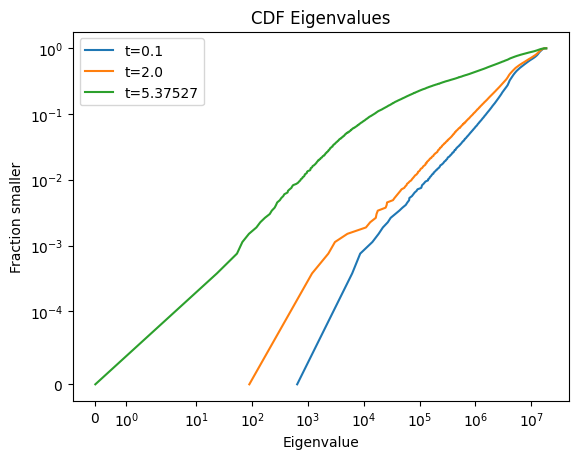

In [455]:
mat1 = getMatrix( path + 'timestepsReduced/stiffness_ogs_global_matrix_cnt_006_t_0.1_pcs_0_Jac.mat')
mat2 = getMatrix( path + 'timestepsReduced/stiffness_ogs_global_matrix_cnt_134_t_2_pcs_0_Jac.mat')
mat3 = getMatrix( path + 'timestepsReduced/stiffness_ogs_global_matrix_cnt_624_t_5.37527_pcs_0_Jac.mat')

mat1 = apply_Dirichlet_bc_boundary(mat1, points, 0, leftX, rightX, bottomY)
mat2 = apply_Dirichlet_bc_boundary(mat2, points, 0, leftX, rightX, bottomY)
mat3 = apply_Dirichlet_bc_boundary(mat3, points, 0, leftX, rightX, bottomY)

CDF(mat1, mat2, mat3, "t=0.1", "t=2.0", "t=5.37527")

In [457]:
def interpolation( fx1, fx2, x ):
    x = x%1
    #f_1 + (f_2-f_1)/(x_2-x_1) * (x-x_1); x_1=0, x_2=1
    return fx1+(fx2-fx1)*(x)

In [576]:
#evalueList == 1 -> path points to list of eigenvalues
def slopeExtrapolation(path, evalueList):
    print( "Start" )
    eigenvalues_list = []
    time_list = []
    f_list = [] 
    f = [1, 1, 1, 1, 1.10375, 1.23153, 1.31062, 1.62338] #f_trial for [0s, 1s, 2s, 3s, 4s, 5s, 6s, 7s]

    for i in range (1, 22):
        time_list.extend( [i*0.1] )
    time_list.extend( [2.22, 2.364, 2.5368, 2.74416, 2.99299, 3.06764, 3.14229, 3.21694, 3.29159, 3.36624, 3.44089, 3.51554, 3.59019, 3.66484, 3.73949, 3.81414, 3.88879, 3.96344, 4.03809, 4.11274, 4.18739, 4.26204, 4.33668, 4.41133, 4.48598, 4.56063, 4.63528, 4.70993, 4.78458, 4.85923, 4.93388, 5.00853, 5.08318, 5.15783, 5.23248, 5.30713, 5.34445, 5.36312, 5.36732, 5.36921, 5.37091, 5.37261, 5.37337, 5.37406, 5.37437, 5.37453, 5.37467, 5.37477, 5.37487, 5.37497, 5.37517, 5.37527 ] )
    
    for i in range( 0, len(time_list) ):
        f_list.extend( [interpolation( f[int(time_list[i])], f[int(time_list[i]+1)], time_list[i] )] )

    

    if(evalueList == 1):
        # Program to read single line in a file using readline() function
        file = open(path, "r")
        while True:
        	content=file.readline()
        	if not content:
        		break
        	eigenvalues_list.extend( [abs(float(content))] )
        file.close()
    else:
        list = os.listdir(path + 'Jac')
        list.sort()
        for i_path in list:
            mat = getMatrix( path + "Jac/" + i_path)
            mat = apply_Dirichlet_bc_boundary(mat, points, 0, leftX, rightX, bottomY)

            eigenvalues_list.extend(getEigenmode( mat, int( len(mat[0])-1 ) ))

    for i in range(0, 25):
        del eigenvalues_list[0]
        del f_list[0]

    f_inter = []
    eval_inter = []
    for i in range(1, 20):
        f_inter.extend([f_list[len(f_list)-i]])
        eval_inter.extend([eigenvalues_list[len(f_list)-i]])

    #z= np.polyfit(f_list, eigenvalues_list, 4)
    z = np.polyfit(f_inter, eval_inter, 3)
    f = np.poly1d(z)

    f_list_ext = [1.2440127747, 1.2499168432, 1.2558209116999999, 1.2607308189, 1.2608652719, 1.2609997249, 1.261055, 1.26106, 1.26107, 1.26108, 1.26109, 1.261095, 1.261096, 1.2610965]
    eigenvalues_list_ext = f(f_list_ext)

    plt.axhline(y=1e-4, color='black')
    plt.axvline(x=f_list[len(f_list)-1], color='black')
    plt.plot(f_list_ext, eigenvalues_list_ext, label="extrapolation")
    plt.plot(np.array(f_list), np.array(eigenvalues_list), 'o', label="simulation data")
    #plt.plot(np.array(f_list), np.array(eigenvalues_list))
    plt.xlabel('F_trial') 
    plt.ylabel('Eigenvalue') 
    plt.yscale('symlog', linthresh=1e-4)
    plt.ylim(0, 10e3)
    plt.title('Extrapolation Eigenvalues') 
    #plt.grid(True) 
    plt.legend(loc='upper right')
    plt.savefig('data/eigenvalues/EigenvalueExtrapolation' + '.pdf')
  
    plt.show() 
    print("End")

Start
73
73
73


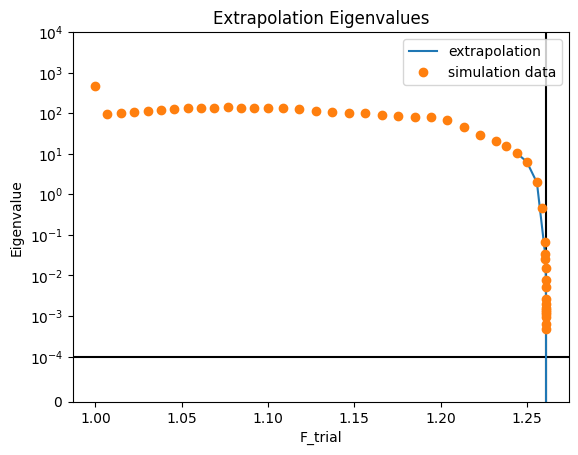

End


In [577]:
#saveSmallestEigenvalues( path, path + "eigenvalues/smallest.txt" )
slopeExtrapolation( path + "eigenvalues/smallest.txt", 1 )